In [11]:
!pip install pygraphviz

  Using cached https://files.pythonhosted.org/packages/7e/b1/d6d849ddaf6f11036f9980d433f383d4c13d1ebcfc3cd09bc845bda7e433/pygraphviz-1.5.zip
  Running setup.py bdist_wheel for pygraphviz ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/65/54/69/1aee9e66ab19916293208d4c9de0d3898adebe6b2eeff6476b
Successfully built pygraphviz
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import pickle

#from src.models import HLGC

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

def straight_through_estimator(logits):
    argmax = torch.eq(logits, logits.max(-1, keepdim=True).values).to(logits.dtype)
    return (argmax - logits).detach() + logits

def gumbel_softmax(logits, temperature=1.0, eps=1e-20):
    u = torch.rand(logits.size(), dtype=logits.dtype, device=logits.device)
    g = -torch.log(-torch.log(u + eps) + eps)
    return F.softmax((logits + g) / temperature, dim=-1)

class CategoricalLayer(nn.Module):
    def __init__(self, input_dim, categorical_dim, output_dim=None):
        super().__init__()
        
        if output_dim == None:
            output_dim = input_dim
            
        self.dense_in = nn.Linear(input_dim, categorical_dim, bias=True)
        self.dense_out = nn.Linear(input_dim+categorical_dim, output_dim, bias=True)
        
    def forward(self, inputs, straight_through=True, sample=False, temperature=1.0, return_logits=False):
        logits = self.dense_in(inputs)
        
        if sample:
            dist = gumbel_softmax(logits, temperature=temperature)
        else:
            dist = F.softmax(logits, dim=-1)
            
        if straight_through:
            dist = straight_through_estimator(dist)
            
        h = torch.tanh(self.dense_out(torch.cat([inputs, dist], dim=-1)))
        
        if return_logits:
            return h, dist, logits
        else:
            return h, dist
    
class HLGC(nn.Module):
    def __init__(self, n_classes, input_dim, categorical_dims, hidden_dim=128, dropout_rate=0.5, batch_size=16,
                 lr=0.001, val_split=0.1, n_epochs=25, class_weights=None, recon_loss_weight=1.0, latent_loss_weight=1.0, 
                 l1_lambda=0.001, display_interval=100, early_stopping_epochs=5, label_dict=None):
        super().__init__()
        
        self.n_classes = n_classes
        self.input_dim = input_dim
        self.categorical_dims = categorical_dims
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size
        self.lr = lr
        self.n_epochs = n_epochs
        self.val_split = val_split
        self.class_weights = class_weights
        self.recon_loss_weight = recon_loss_weight
        self.latent_loss_weight = latent_loss_weight
        self.l1_lambda = l1_lambda
        self.display_interval = display_interval
        self.early_stopping_epochs = early_stopping_epochs
        self.label_dict = label_dict
        
        if type(self.class_weights) is not torch.tensor:
            self.class_weights = torch.tensor(self.class_weights, dtype=torch.float32)
        
        self._build_model()
        
    def _build_model(self):
        # classifier
        self.input_dense = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        
        self.categorical_layers = nn.ModuleList([
            CategoricalLayer(self.hidden_dim, dim) for dim in self.categorical_dims
        ])
        
        self.global_dense = nn.Linear(sum(self.categorical_dims), self.hidden_dim, bias=True)
        self.out_dense = nn.Linear(self.hidden_dim, self.n_classes, bias=True)
        self.dropout = nn.Dropout(self.dropout_rate)
                
        # generator
        self.encoder = nn.ModuleList([
            nn.Linear(self.hidden_dim+dim, self.hidden_dim, bias=True) for dim in self.categorical_dims
        ])
        self.encoder_out = nn.Linear(self.hidden_dim, self.n_classes, bias=True) 
        
        self.decoder_in = nn.Linear(self.n_classes, self.hidden_dim, bias=True)
        self.decoder = nn.ModuleList([
            CategoricalLayer(self.hidden_dim, dim) for dim in self.categorical_dims
        ])
        
    def _calc_loss(self, targets, clf_logits, support_logits, clf_states, gen_logits, gen_states, z):
        # flat classification loss
        clf_loss = nn.CrossEntropyLoss(weight=self.class_weights)(clf_logits, targets)
        
        # support classification loss
        support_loss = nn.CrossEntropyLoss(weight=self.class_weights)(support_logits, targets)

        # generator DAG reconstruction loss
        recon_loss = 0.0
        for clf_state, gen_logit in zip(clf_states, gen_logits):
            recon_loss += nn.CrossEntropyLoss()(gen_logit, clf_state.argmax(-1))
        recon_loss /= len(clf_states)

        # generator latent loss
        latent_loss = nn.CrossEntropyLoss(weight=self.class_weights)(z, clf_logits.argmax(-1))
        
        # L1 regularization
        l1_loss = 0.0
        for param in self.global_dense.parameters():
            l1_loss += torch.norm(param, 1)

        loss = (
            clf_loss + 
            support_loss +
            self.recon_loss_weight*recon_loss +
            self.latent_loss_weight*latent_loss + 
            self.l1_lambda*l1_loss
        )
        return loss, clf_loss, support_loss, recon_loss, latent_loss
    
    def _calc_metrics(self, targets, clf_logits, clf_states, gen_states):
        clf_acc = (targets == clf_logits.argmax(-1)).to(float).mean()

        recon_acc = 0.0
        for clf_state, gen_state in zip(clf_states, gen_states):
            recon_acc += (clf_state.argmax(-1) == gen_state.argmax(-1)).to(float).mean()
        recon_acc /= len(clf_states)

        return clf_acc, recon_acc
        
    def encode(self, dists):
        h = torch.zeros(dists[0].size(0), self.hidden_dim, device=dists[0].device) 
        
        for dist, layer in zip(dists, self.encoder):
            h = torch.tanh(layer(torch.cat([h, dist], dim=-1))) 
        z = self.encoder_out(h)
        return z
    
    def generate(self, z_sample, straight_through=True, temperature=0.1): 
        h = torch.tanh(self.decoder_in(z_sample))
        
        gen_states, gen_logits = [], []
        for layer in self.decoder:
            h, dist, logits = layer(
                h, straight_through=straight_through, temperature=temperature, sample=True, 
                return_logits=True
            )
            gen_states.append(dist)
            gen_logits.append(logits)
        return gen_states, gen_logits
    
    def generate_dag(self, display=True):
        # generate edges
        edges, labeled_paths = [], []
        for i, z in enumerate(torch.eye(self.n_classes)):
            states, _ = self.generate(z)
            path = [x.argmax(-1).item() for x in states]
            nodes = ['ROOT'] + ['{}_{}'.format(i, x) for i, x in enumerate(path)]
            edges += [(nodes[i], nodes[i+1]) for i in range(len(nodes)-1)]

            label = self.label_dict[i] if self.label_dict else i
            labeled_paths.append((label, path))
        labeled_paths = sorted(labeled_paths, key=lambda x : x[1][0])

        # print labeled paths
        curr = labeled_paths[0][1][0]
        for l, p in labeled_paths: 
            if curr != p[0]:
                print('-----')
            print('{} : {}'.format(l, p))
            curr = p[0]

        # construct DAG
        G = nx.DiGraph()
        G.add_node('ROOT')
        G.add_edges_from(edges)

        # display DAG
        plt.title('DAG')
        pos=graphviz_layout(G, prog='dot')
        nx.draw(G, pos)
        plt.show()
        return G, labeled_paths
    
    def classify(self, inputs, return_states=False):
        h_0 = torch.tanh(self.input_dense(inputs))
        self.dropout(h_0)
        
        h = h_0
        states = []
        for layer in self.categorical_layers:
            h, dist = layer(h, straight_through=True, sample=False)
            states.append(dist)
            
        h = torch.tanh(self.global_dense(torch.cat(states, dim=-1)))
        support_logits = self.out_dense(h)
        clf_logits = self.out_dense(h_0)
        
        if return_states:
            return clf_logits, support_logits, states
        else:
            return clf_logits
        
    def forward(self, inputs, temperature=1.0):
        # classifier
        clf_logits, support_logits, clf_states = self.classify(inputs, return_states=True)
        
        # generator
        z = self.encode([x.detach() for x in clf_states])
        z_sample = straight_through_estimator(gumbel_softmax(z, temperature=temperature))
        gen_states, gen_logits = self.generate(z_sample, straight_through=True, temperature=temperature)
        return clf_logits, support_logits, clf_states, gen_logits, gen_states, z
    
    def score(self, features, targets):
        data_loader = DataLoader(list(zip(features, targets)), batch_size=self.batch_size)

        self.eval()
        eval_loss, eval_clf_loss, eval_support_loss, eval_recon_loss, eval_latent_loss, eval_clf_acc, eval_recon_acc = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch in data_loader:
                batch_features, batch_targets = batch
                clf_logits, support_logits, clf_states, gen_logits, gen_states, z = self.forward(batch_features)

                loss, clf_loss, support_loss, recon_loss, latent_loss = self._calc_loss(
                    batch_targets, clf_logits, support_logits, clf_states, gen_logits, gen_states, z
                )

                clf_acc, recon_acc = self._calc_metrics(batch_targets, clf_logits, clf_states, gen_states)

                scale = len(batch_features)/len(features)
                eval_loss += loss.item()*scale
                eval_clf_loss += clf_loss.item()*scale
                eval_support_loss += support_loss.item()*scale
                eval_recon_loss += recon_loss.item()*scale
                eval_latent_loss += latent_loss.item()*scale
                eval_clf_acc += clf_acc.item()*scale
                eval_recon_acc += recon_acc.item()*scale
            print(
                '[ Eval ] loss - (total : {:3f}, clf : {:3f}, support : {:3f}, recon : {:3f}, latent : {:3f}), \
acc - (clf : {:3f}, recon : {:3f})'.format(eval_loss, eval_clf_loss, eval_support_loss, eval_recon_loss, eval_latent_loss, 
                                                   eval_clf_acc, eval_recon_acc)
            )
        return eval_clf_acc
    
    def fit(self, train_features, train_targets, val_features=None, val_targets=None):
        if (val_features is None) or (val_targets is None):
            print('No validation data provided, using {}% of train data'.format(100*self.val_split))
            
            train_data, val_data = train_test_split(
                list(zip(train_features, train_targets)), test_size=self.val_split, random_state=0
            )
            train_features, train_targets = zip(*train_data)
            val_features, val_targets = zip(*val_data)
        
        train_loader = DataLoader(
            list(zip(train_features, train_targets)), 
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        optimizer = optim.Adam(
            filter(lambda x: x.requires_grad, self.parameters()), betas=(0.9, 0.98),
            eps=1e-09,
            lr=self.lr
        )
        
        itr, since_best = 0, 0
        best_acc, best_loss = 0.0, 10e9
        for epoch in range(self.n_epochs):
            self.train()
            for batch in train_loader:
                itr += 1

                batch_features, batch_targets = batch
                clf_logits, support_logits, clf_states, gen_logits, gen_states, z = self.forward(batch_features)

                loss, clf_loss, support_loss, recon_loss, latent_loss = self._calc_loss(
                    batch_targets, clf_logits, support_logits, clf_states, gen_logits, gen_states, z
                )

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5)
                optimizer.step()
                optimizer.zero_grad()

                if itr == 1 or itr % self.display_interval == 0:
                    clf_acc, recon_acc = self._calc_metrics(batch_targets, clf_logits, clf_states, gen_states)

                    log_string = '[{}, {:5d}] loss - (total : {:3f}, clf : {:3f}, support : {:3f}, recon : {:3f}, latent : {:3f}), \
acc - (clf : {:3f}, recon : {:3f})'.format(epoch, itr, loss.item(), clf_loss.item(), support_loss.item(), recon_loss.item(),
                                                   latent_loss.item(), clf_acc.item(), recon_acc.item())
                    print(log_string)

            val_acc = self.score(val_features, val_targets)
            if val_acc > best_acc:
                best_acc = val_acc
                since_best = 0
            else:
                since_best += 1
                
            _, _ = self.generate_dag()
                
            if since_best == self.early_stopping_epochs:
                break
        print('Training complete!')

In [14]:
data = pickle.load(open('data/cifar100-resnet18.pickle', 'rb'))

In [15]:
hparams = {
    'n_features' : len(data['train']['features'][0]),
    'hidden_dim' : 128,
    'latent_dims' : [50, 50, 50, 50, 50],
    'batch_size' : 32,
    'lr' : 0.001,
    'dropout' : 0.5,
    'n_epochs' : 25,
    'early_stopping_epochs' : 5,
    'latent_loss_weight' : 1.0,
    'recon_loss_weight' : 1.0,
    'l1_lambda' : 0.001, 
    'val_split' : 0.1, 
    'display_interval' : 200
}

In [16]:
model = HLGC(
    len(data['flat_label_dict']), hparams['n_features'], hparams['latent_dims'], hidden_dim=hparams['hidden_dim'], 
    dropout_rate=hparams['dropout'], batch_size=hparams['batch_size'], lr=hparams['lr'], 
    n_epochs=hparams['n_epochs'], class_weights=data['class_weights'], recon_loss_weight=hparams['recon_loss_weight'], 
    latent_loss_weight=hparams['latent_loss_weight'], 
    l1_lambda=hparams['l1_lambda'], display_interval=hparams['display_interval'], 
    early_stopping_epochs=hparams['early_stopping_epochs'], label_dict=data['flat_label_dict']
)

No validation data provided, using 10.0% of train data
[0,     1] loss - (total : 14.187124, clf : 4.609221, support : 4.589177, recon : 3.930701, latent : 4.628667), acc - (clf : 0.000000, recon : 0.018750)
[0,   200] loss - (total : 10.774097, clf : 4.330169, support : 4.969571, recon : 0.749599, latent : 5.650770), acc - (clf : 0.031250, recon : 0.550000)
[0,   400] loss - (total : 5.347847, clf : 4.333570, support : 4.950388, recon : 0.520186, latent : 0.441242), acc - (clf : 0.000000, recon : 0.693750)
[0,   600] loss - (total : 8.309396, clf : 4.338863, support : 5.164587, recon : 0.725185, latent : 3.185488), acc - (clf : 0.031250, recon : 0.731250)
[0,   800] loss - (total : 5.660511, clf : 4.296215, support : 5.305485, recon : 0.511094, latent : 0.780735), acc - (clf : 0.000000, recon : 0.706250)
[0,  1000] loss - (total : 6.649076, clf : 4.111740, support : 5.109371, recon : 0.543867, latent : 1.912504), acc - (clf : 0.000000, recon : 0.668750)
[0,  1200] loss - (total : 5.91

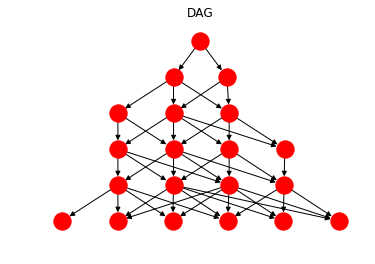

[1,  1600] loss - (total : 6.268287, clf : 3.908968, support : 4.977989, recon : 0.774482, latent : 1.483692), acc - (clf : 0.031250, recon : 0.681250)
[1,  1800] loss - (total : 6.204092, clf : 3.800316, support : 5.100410, recon : 0.700322, latent : 1.593848), acc - (clf : 0.125000, recon : 0.650000)
[1,  2000] loss - (total : 4.998178, clf : 3.435519, support : 5.449022, recon : 0.445652, latent : 0.997192), acc - (clf : 0.062500, recon : 0.756250)
[1,  2200] loss - (total : 4.920983, clf : 3.844052, support : 5.030985, recon : 0.538030, latent : 0.416656), acc - (clf : 0.031250, recon : 0.731250)
[1,  2400] loss - (total : 5.380788, clf : 3.336417, support : 5.391228, recon : 0.484893, latent : 1.438671), acc - (clf : 0.187500, recon : 0.793750)
[1,  2600] loss - (total : 5.135954, clf : 3.229135, support : 5.471776, recon : 0.408754, latent : 1.373930), acc - (clf : 0.125000, recon : 0.731250)
[1,  2800] loss - (total : 4.671478, clf : 3.418290, support : 5.300439, recon : 0.35017

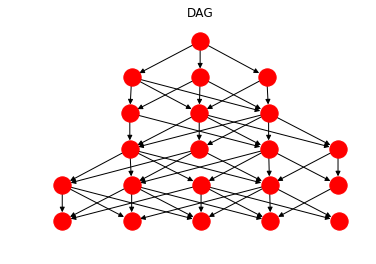

[2,  3000] loss - (total : 5.674990, clf : 3.386899, support : 5.481439, recon : 0.529796, latent : 1.628945), acc - (clf : 0.125000, recon : 0.706250)
[2,  3200] loss - (total : 5.059787, clf : 3.673228, support : 5.619442, recon : 0.408756, latent : 0.848610), acc - (clf : 0.031250, recon : 0.775000)
[2,  3400] loss - (total : 3.849889, clf : 2.915190, support : 5.318165, recon : 0.324093, latent : 0.484842), acc - (clf : 0.062500, recon : 0.856250)
[2,  3600] loss - (total : 4.432250, clf : 2.989656, support : 5.943193, recon : 0.364017, latent : 0.951535), acc - (clf : 0.156250, recon : 0.818750)
[2,  3800] loss - (total : 4.237017, clf : 3.321819, support : 5.892657, recon : 0.377345, latent : 0.413878), acc - (clf : 0.031250, recon : 0.775000)
[2,  4000] loss - (total : 4.701378, clf : 3.578345, support : 5.173715, recon : 0.308624, latent : 0.692747), acc - (clf : 0.218750, recon : 0.843750)
[2,  4200] loss - (total : 4.585573, clf : 3.328471, support : 5.447096, recon : 0.30836

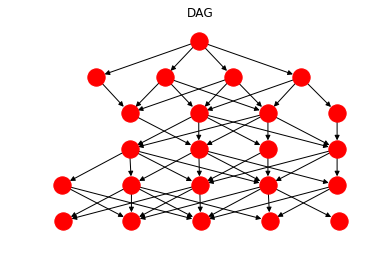

[3,  4400] loss - (total : 4.629884, clf : 3.364336, support : 5.841702, recon : 0.421445, latent : 0.720708), acc - (clf : 0.187500, recon : 0.800000)
[3,  4600] loss - (total : 4.571609, clf : 3.339375, support : 5.647437, recon : 0.312347, latent : 0.796711), acc - (clf : 0.093750, recon : 0.806250)
[3,  4800] loss - (total : 4.300558, clf : 3.344461, support : 5.506537, recon : 0.312097, latent : 0.523431), acc - (clf : 0.093750, recon : 0.837500)
[3,  5000] loss - (total : 5.193659, clf : 3.375967, support : 5.976897, recon : 0.580796, latent : 1.114591), acc - (clf : 0.062500, recon : 0.737500)
[3,  5200] loss - (total : 4.542636, clf : 3.179148, support : 5.089445, recon : 0.481207, latent : 0.761740), acc - (clf : 0.156250, recon : 0.793750)
[3,  5400] loss - (total : 3.649871, clf : 2.941951, support : 5.816833, recon : 0.391464, latent : 0.195071), acc - (clf : 0.250000, recon : 0.806250)
[3,  5600] loss - (total : 4.075134, clf : 3.104647, support : 5.766101, recon : 0.33469

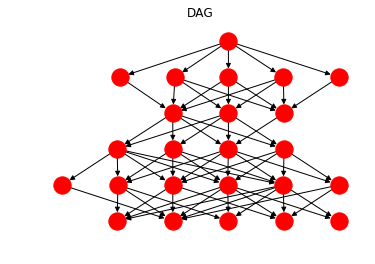

[4,  5800] loss - (total : 4.260998, clf : 2.859225, support : 5.486303, recon : 0.493472, latent : 0.788034), acc - (clf : 0.187500, recon : 0.818750)
[4,  6000] loss - (total : 3.407314, clf : 2.768630, support : 5.826021, recon : 0.284091, latent : 0.235829), acc - (clf : 0.062500, recon : 0.843750)
[4,  6200] loss - (total : 3.571933, clf : 2.806032, support : 5.920691, recon : 0.245216, latent : 0.401649), acc - (clf : 0.250000, recon : 0.850000)
[4,  6400] loss - (total : 3.934099, clf : 3.260770, support : 5.639685, recon : 0.264589, latent : 0.291704), acc - (clf : 0.187500, recon : 0.862500)
[4,  6600] loss - (total : 4.104592, clf : 3.052400, support : 5.518740, recon : 0.483487, latent : 0.451175), acc - (clf : 0.187500, recon : 0.787500)
[4,  6800] loss - (total : 3.881112, clf : 2.841569, support : 6.024658, recon : 0.350324, latent : 0.573868), acc - (clf : 0.125000, recon : 0.812500)
[4,  7000] loss - (total : 3.678948, clf : 2.802759, support : 6.445207, recon : 0.33932

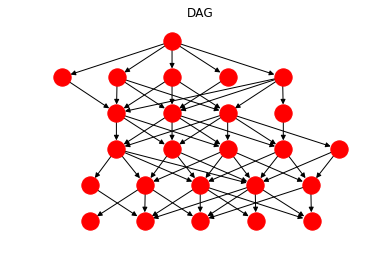

[5,  7200] loss - (total : 4.151301, clf : 3.172668, support : 6.092498, recon : 0.385489, latent : 0.478660), acc - (clf : 0.156250, recon : 0.787500)
[5,  7400] loss - (total : 3.490740, clf : 2.946673, support : 6.285019, recon : 0.237195, latent : 0.192334), acc - (clf : 0.250000, recon : 0.856250)
[5,  7600] loss - (total : 3.590558, clf : 2.701849, support : 6.542855, recon : 0.338783, latent : 0.436844), acc - (clf : 0.281250, recon : 0.856250)
[5,  7800] loss - (total : 4.037935, clf : 3.087577, support : 6.801178, recon : 0.331864, latent : 0.506373), acc - (clf : 0.156250, recon : 0.837500)
[5,  8000] loss - (total : 4.094203, clf : 2.988658, support : 7.074775, recon : 0.256428, latent : 0.738438), acc - (clf : 0.156250, recon : 0.843750)
[5,  8200] loss - (total : 3.954479, clf : 2.996130, support : 7.013103, recon : 0.290260, latent : 0.559331), acc - (clf : 0.218750, recon : 0.862500)
[5,  8400] loss - (total : 3.843123, clf : 2.986411, support : 6.769441, recon : 0.34558

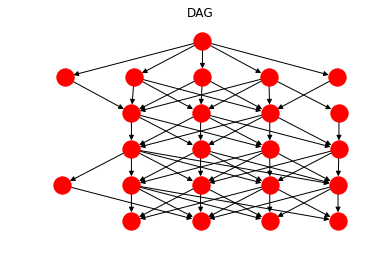

[6,  8600] loss - (total : 3.431310, clf : 2.607111, support : 7.331555, recon : 0.316309, latent : 0.401982), acc - (clf : 0.312500, recon : 0.843750)
[6,  8800] loss - (total : 3.388639, clf : 2.778372, support : 7.131109, recon : 0.242478, latent : 0.260270), acc - (clf : 0.281250, recon : 0.887500)
[6,  9000] loss - (total : 3.740907, clf : 2.947504, support : 5.889904, recon : 0.308529, latent : 0.376304), acc - (clf : 0.343750, recon : 0.825000)
[6,  9200] loss - (total : 3.341097, clf : 2.625089, support : 7.269833, recon : 0.300893, latent : 0.308495), acc - (clf : 0.156250, recon : 0.806250)
[6,  9400] loss - (total : 3.408352, clf : 2.637015, support : 6.038495, recon : 0.252979, latent : 0.412927), acc - (clf : 0.218750, recon : 0.868750)
[6,  9600] loss - (total : 3.745509, clf : 2.891849, support : 6.944243, recon : 0.371123, latent : 0.378827), acc - (clf : 0.218750, recon : 0.806250)
[6,  9800] loss - (total : 3.273778, clf : 2.691770, support : 6.792006, recon : 0.25714

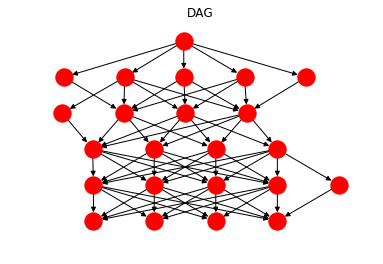

[7, 10000] loss - (total : 3.685036, clf : 2.984851, support : 7.129210, recon : 0.336347, latent : 0.259329), acc - (clf : 0.312500, recon : 0.793750)
[7, 10200] loss - (total : 4.064511, clf : 3.506548, support : 7.455114, recon : 0.309323, latent : 0.144674), acc - (clf : 0.125000, recon : 0.881250)


KeyboardInterrupt: 

In [17]:
model.fit(data['train']['features'], data['train']['flat_labels'])

In [ ]:
model.score(data['test']['features'], data['test']['flat_labels'])